# Setup

In [1]:
from io import BytesIO
from shutil import rmtree

import plotly.express as px
import requests
from shapely import Polygon
from sklearn.linear_model import LinearRegression
from zipfile import ZipFile

from utils import *

## Load block groups

In [2]:
bgs = view(pd.read_parquet(
    'data/geometry/zones.parquet',
    filters=[('level', '==', 'BG')],
    columns=['geoid', 'city']))

106,044 rows x 2 cols; Memory: 6.3 MiB


,geoid,city
,<object>,<category>
0,280330705233,Memphis


# Access Across America (AAA)
From [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**


## Download AAA data (2022)
After the latest change in their website, the URLs for the different states' access datasets could not be extracted automatically by scraping. They were thus manually collected via their 'handles' (URIs) and stored in a file `data/aaa/urls.csv_2022`.

In [3]:
handles = view(pd.read_csv('data/access/aaa/urls_2022.csv'))

153 rows x 3 cols; Memory: 0.0 MiB


,mode_,state,handle
,<object>,<object>,<object>
0,Bike,Alabama,2dcf58f6-5a78-4b28-9de1-5fc29c606099


In [4]:
tmp = mkdir('data/tmp') # temporary data directory
for _, r in tqdm(handles.iterrows(), total=len(handles)):
    url = f'https://conservancy.umn.edu/bitstreams/{r.handle}/download'
    try:
        with ZipFile(BytesIO(requests.get(url).content)) as z:
            for level in ['county', 'census_tract', 'block_group', 'block']:
                fname = sorted([f.filename for f in z.filelist
                                if level in f.filename])[0]
                z.extract(fname, tmp)
                df = pd.read_csv(tmp / fname, usecols=[
                    'Census ID', 'Threshold', 'total_jobs' if 
                    level == 'block' else 'Weighted_average_total_jobs'])
                df.columns = ['geoid', 'thresh', 'access']
                df = df[df.thresh.isin([15, 30, 45, 60])]
                df = df.astype(D(thresh=CAT, access=F32))
                df = df.reset_index(drop=1)
                outpath = 'data/access/aaa/2022/{}-{}-{}.parquet'.format(
                    r.state, r.mode_.lower(), level).replace(' ', '_')
                df.to_parquet(outpath, compression='gzip')
    except Exception as e:
        print('ERROR:', r.mode_, r.state, level, e)
rmtree(tmp) # 7m3s

Load the AAA data

In [5]:
aaa = []
# geoids = saa.geoid.unique().astype(int)
for mode in ['drive', 'walk', 'bike']:
    for f in glob(f'data/access/aaa/2022/*-{mode}-block_group.parquet'):
        df = pd.read_parquet(f).rename(columns=D(access='aaa'))
        df.geoid = df.geoid.astype(str).str.zfill(12)
        df = df.merge(bgs, on='geoid')
        aaa.append(df.assign(mode=mode.title()))
aaa = view(pd.concat(aaa).astype(D(geoid=str, thresh=str))
           .astype(D(geoid=CAT, thresh=CAT, mode=CAT))
           [['mode', 'thresh', 'city', 'geoid', 'aaa']])

892,106 rows x 5 cols; Memory: 26.3 MiB


,mode,thresh,city,geoid,aaa
,<category>,<category>,<category>,<category>,<float32>
0,Drive,30,San Francisco,060014001001,894025.75


## Recompute our SAA access
Recompute the Spatial Access of America (SAA) values to compare our access with the AAA values to the best feasible comparison. Some things to note in this calculation:
- Only total job counts of 2020 are used as opportunities because the AAA data (2022 version) only uses total jobs using the 2020 LODES data.
- Travel times are computed using the R5 routing engine instead of OSRM because walking, biking & public transit travel times in the AAA dataset are obtained using R5.
- Driving times are only available in select states and thus only a few of our study cities within those states.

In [6]:
jobs = pd.read_parquet(
    'data/opport/jobs_2020.parquet',
    filters=[('level', '==', 'BG'), ('kind', '==', 'All')],
    columns=['geoid', 'njobs'])
jobs = view(jobs.merge(bgs[['geoid']])) # 7s

105,135 rows x 2 cols; Memory: 6.5 MiB


,geoid,njobs
,<object>,<int32>
0,040130101022,162


In [7]:
saa = []
for f in tqdm(glob('data/ttm/r5/*.parquet')):
    city, mode = f.split('/')[-1].split('_')[:2]
    if city != 'houston': continue
    if mode == 'transit':
        continue
    tt = pd.read_parquet(f, columns=['src', 'trg', 'time'])
    tt = tt.merge(jobs.rename(columns=D(geoid='trg')))
    for thresh in (15, 30, 45, 60, 90):
        df = (tt[tt.time <= thresh]
              .groupby('src', observed=1).njobs.sum().rename('saa')
              .rename_axis('geoid').reset_index())
        saa.append(df.assign(mode=mode.title(), thresh=str(thresh)))
saa = view(pd.concat(saa).merge(bgs, on='geoid').reset_index(drop=1)
           .astype(D(geoid=CAT, mode=CAT, thresh=CAT)))
saa.to_parquet('data/access/saa_jobs_contour_r5.parquet') # 5m24s
# saa = view(pd.read_parquet('data/access/saa_jobs_contour_r5.parquet'))

1,595,823 rows x 5 cols; Memory: 26.9 MiB


,geoid,saa,mode,thresh,city
,<category>,<int32>,<category>,<category>,<category>
0,040130101022,162,Walk,60,Phoenix


## Overall comparison

In [8]:
saa2aaa = view(
    saa.merge(aaa, on=('geoid', 'city', 'mode', 'thresh'))
    .query('aaa > 0').sort_values('city').astype(D(city=str))
    .assign(ratio=lambda df: df.saa / df.aaa))

907,276 rows x 7 cols; Memory: 168.3 MiB


,geoid,saa,mode,thresh,city,aaa,ratio
,<object>,<int32>,<category>,<object>,<object>,<float32>,<float64>
269349,130771704083,257,Bike,15,Atlanta,107.749771,2.385156


<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3553739/323380779.py:25: SyntaxWarning: invalid escape sequence '\m'
  mpl.patches.Patch(fc=color, label='%s\n($\mu$=%.2f)' %
/tmp/ipykernel_3553739/323380779.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/tmp/ipykernel_3553739/323380779.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


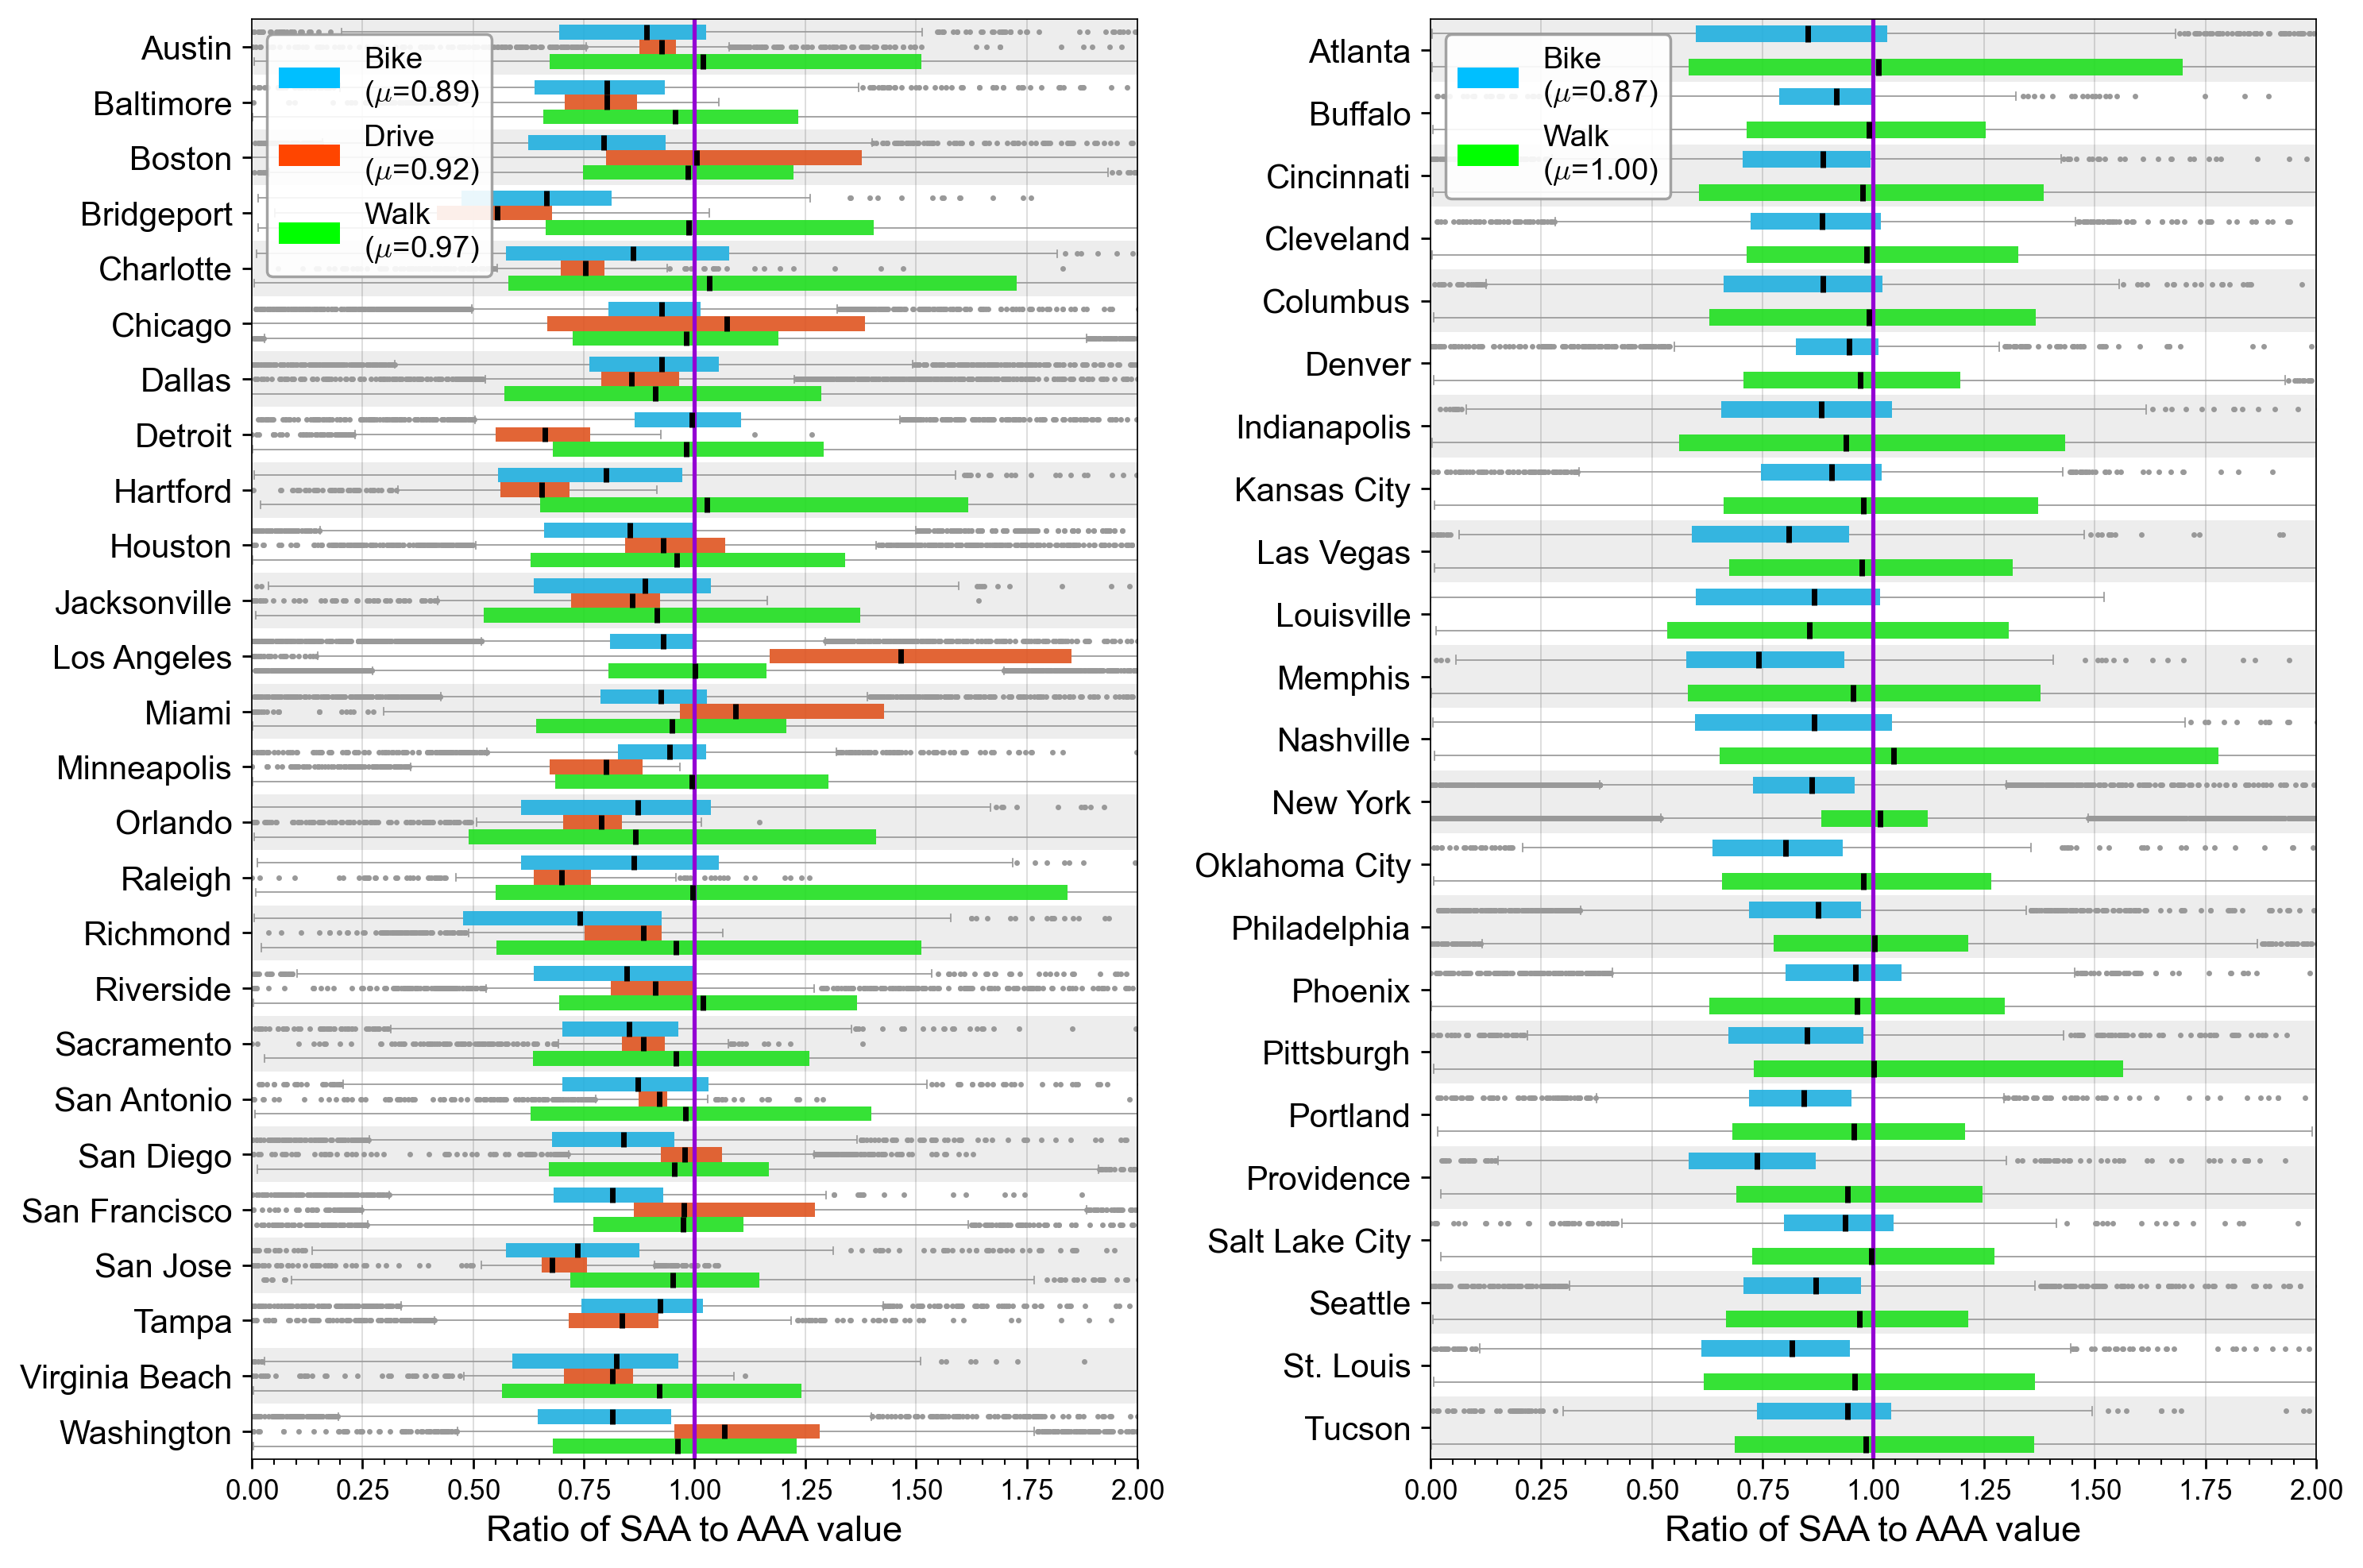

In [9]:
df = filt(saa2aaa, thresh='30')
extra_cities = {'Philadelphia', 'St. Louis'}
df = df[~((df['mode'] == 'Drive') & (df.city.isin(extra_cities)))]
drive_cities = set(filt(df, mode='Drive').city)
other_cities = set(bgs.city) - drive_cities
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=250)
mode_colors = D(Bike='deepskyblue', Drive='orangered', Walk='lime')
for cities, ax in zip([drive_cities, other_cities], axes):
    ax = plot(ax, xlim=(0, 2), ylim=(-0.5, len(cities) - 0.5),
              xlab='Ratio of SAA to AAA value', yminor=0)
    df2 = df[df.city.isin(cities)].sort_values('city')
    sns.boxplot(df2, ax=ax, y='city', x='ratio', hue='mode',
                fliersize=1, linecolor='.6', linewidth=0.5,
                palette=mode_colors.values(),
                medianprops=D(color='k', lw=2),
                boxprops=D(ec='none', alpha=0.9))
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('')
    for i in range(len(df2.city.unique())):
        color = 'lightgrey' if i % 2 == 0 else 'white'
        ax.axhspan(i - 0.5, i + 0.5, fc=color, alpha=0.4)
    ax.axvline(1, color='darkviolet', lw=1.5)
    medians = df2.groupby('mode', observed=1)['ratio'].median()
    ax.legend(loc='upper left', handles=[
        mpl.patches.Patch(fc=color, label='%s\n($\mu$=%.2f)' % 
                          (mode, medians.loc[mode]))
        for mode, color in mode_colors.items()
        if mode in set(df2['mode'])
    ], facecolor='w', edgecolor='.6', framealpha=0.9)
plt.tight_layout()
imsave('SAA to AAA ratio') # 5s

In [10]:
# mode_colors = D(Bike='deepskyblue', Walk='lime', Drive='orangered')
# _, axes = plt.subplots(1, 6, figsize=(12, 6), dpi=150)
# for i, cities in enumerate(np.array_split(saa2aaa.city.unique(), 2)):
#     df = filt(saa2aaa, thresh='30')
#     df = df[df.city.isin(cities)].copy()
#     df.city = df.city.cat.remove_unused_categories()
#     for j, (mode, color) in enumerate(mode_colors.items()):
#         df2 = filt(df, mode=mode)
#         ax = plot(axes[j + 3 * i], xlim=(0, 2), yminor=0)
#         sns.boxplot(df2, ax=ax, x='ratio', y='city',
#                     fliersize=1, linecolor='.6', linewidth=0.5,
#                     color=color, medianprops=D(color='k', lw=2),
#                     boxprops=D(ec='none', alpha=0.9))
#         ax.set_ylabel('')
#         if j != 0:
#             ax.set_yticklabels('')
# plt.tight_layout()

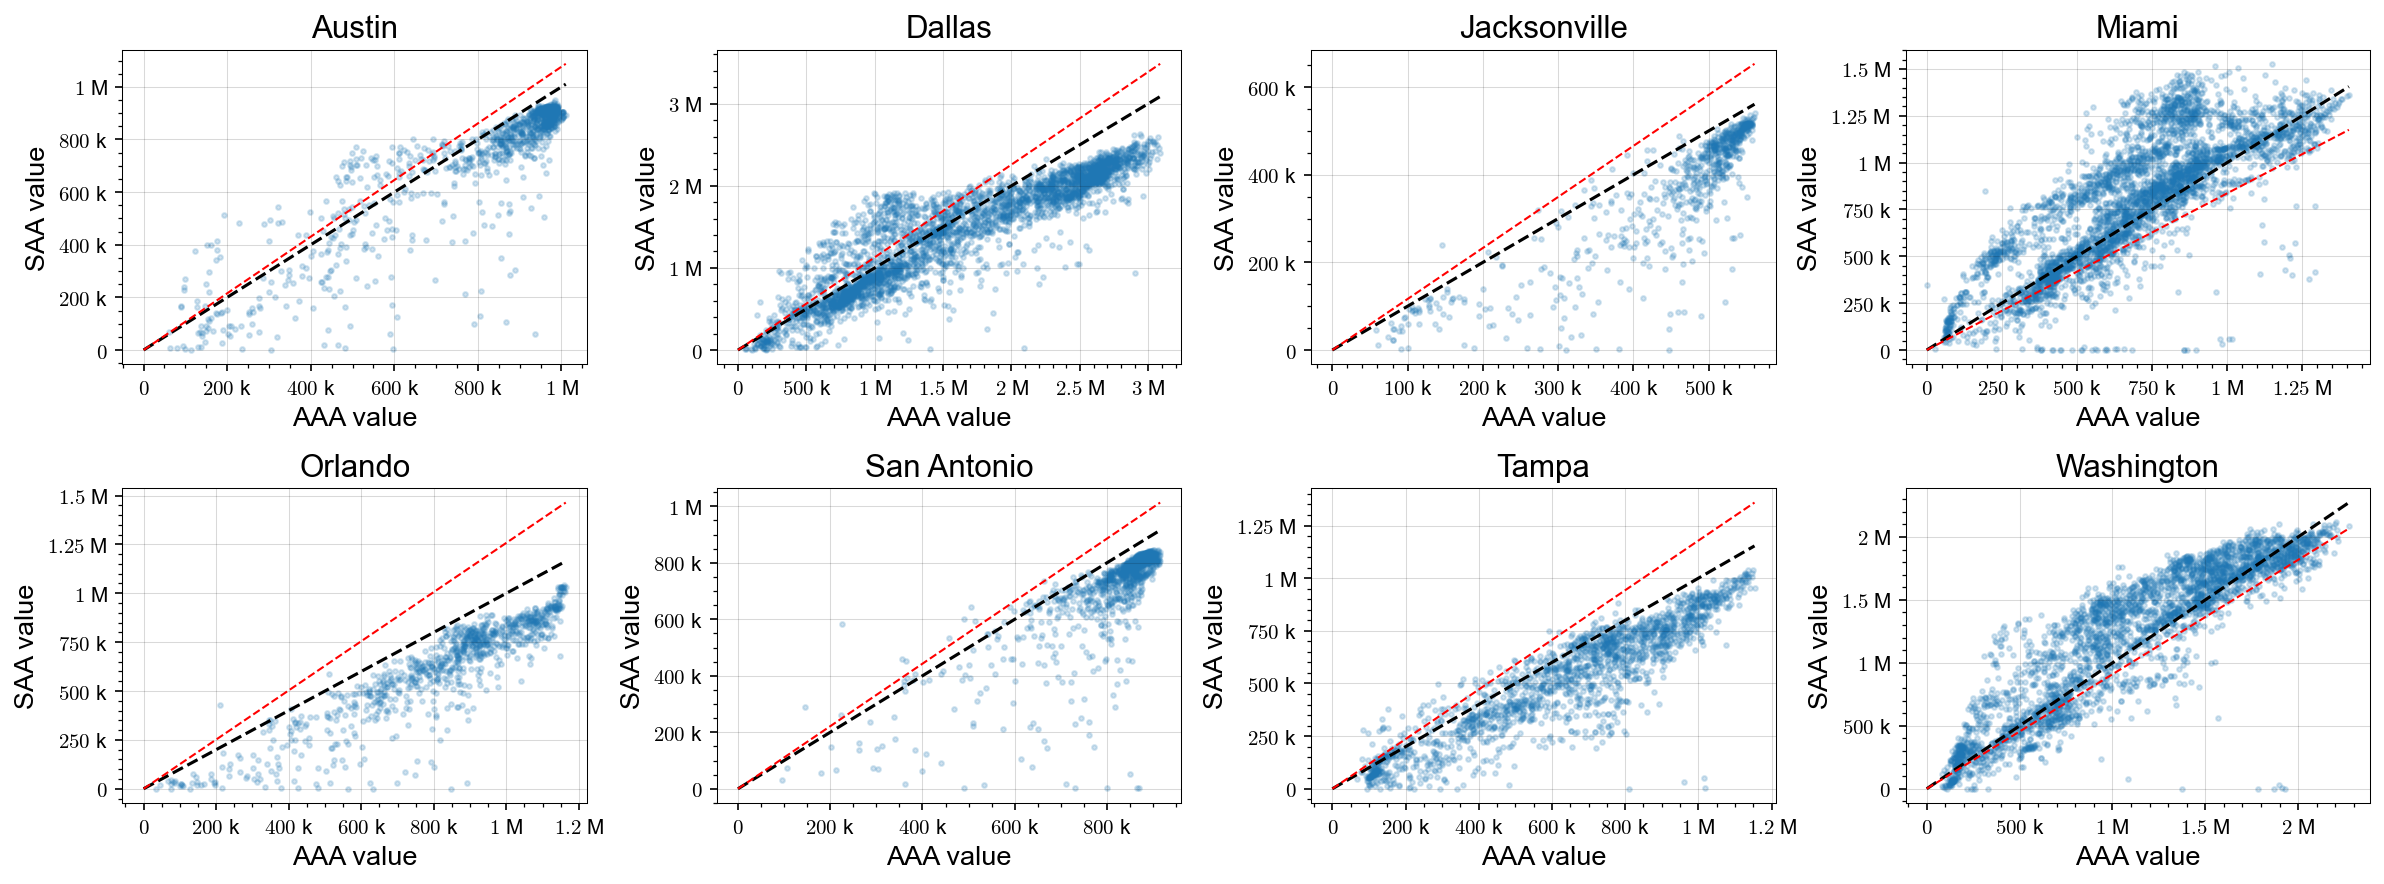

In [11]:
_, axes = plt.subplots(2, 4, figsize=(16, 6), dpi=150)
for i, city in enumerate(['Austin', 'Dallas', 'Jacksonville', 'Miami',
                          'Orlando', 'San Antonio', 'Tampa', 'Washington']):
    ax = plot(axes.flatten()[i], xlab='AAA value', ylab='SAA value',
              title=city, xeng=1, yeng=1)
    df = filt(saa2aaa, city=city, mode='Drive', thresh='30')
    model = (LinearRegression(fit_intercept=False)
             .fit(df[['saa']], df.aaa))
    x = np.linspace(0, (vmax := df.aaa.max()), 100)
    y = (slope := model.coef_[0]) * x
    ax.scatter(df.aaa, df.saa, s=5, alpha=0.2)
    ax.plot([0, vmax], [0, vmax], ls='--', color='k')
    ax.plot(x, y, ls='--', color='r', lw=1)
plt.tight_layout()

### Explore effects of catchment in Chicago

In [12]:
chi_zones = (gpd.read_parquet(
    'data/geometry/zones.parquet',
    columns=['geoid', 'geometry', 'county'],
    filters=[('level', '==', 'BG'), ('city', '==', 'Chicago')])
             .to_crs(CRS_M).astype(D(county=str)))
chi_zones = view(chi_zones[chi_zones.county.isin(['Cook', 'DuPage'])], 0)

4,622 rows x 3 cols; Memory: 0.6 MiB; <Projected CRS: EPSG:3857>


,geoid,geometry,county
,<object>,<geometry>,<object>


In [13]:
chi_tt = view(pd.read_parquet(glob('data/ttm/r5/chicago_drive*')[0],
                              filters=[('time', '<=', 30)]))

12,959,895 rows x 4 cols; Memory: 88.0 MiB


,level,src,trg,time
,<category>,<category>,<category>,<int16>
0,County,18089,18089,0


In [14]:
opport = pd.read_parquet('data/opport/opportunities.parquet')
opport = view(chi_zones.merge(filt(opport, kind='Jobs: All'), on='geoid'))

4,568 rows x 5 cols; Memory: 0.6 MiB; <Projected CRS: EPSG:3857>


,geoid,geometry,county,level,opport
,<object>,<geometry>,<object>,<category>,<int32>
0,170438413161,"POLYGON ((-9819202.406921 5159081.129339, -981...",DuPage,BG,586


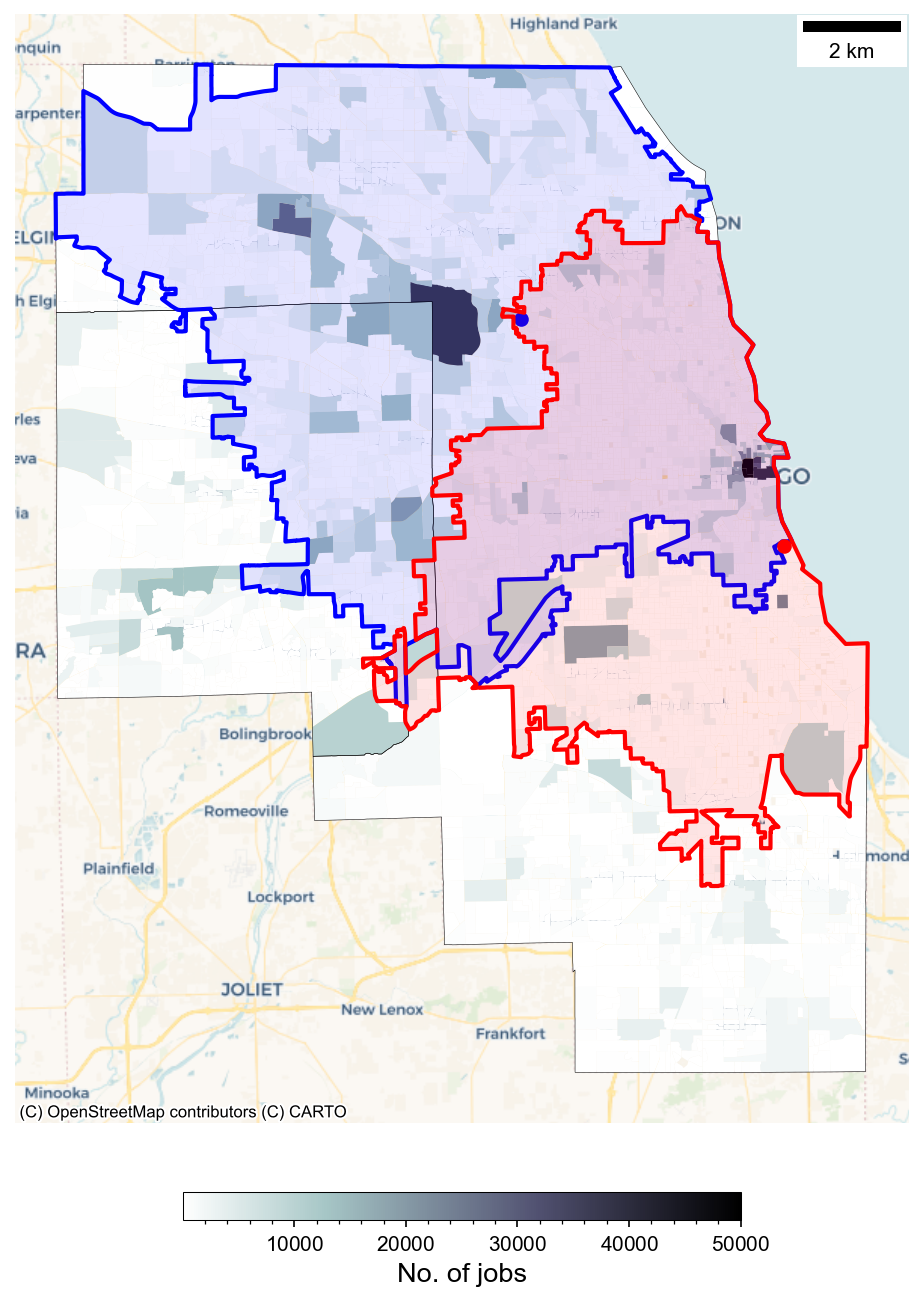

In [15]:
ax = plot(size=(12, 12), dpi=150, axoff=1)
maplot(opport, 'opport', ax=ax, cmap='bone_r', vmax=50_000,
       label='No. of jobs', shrink=0.4, vert=False, cbar_kw=D(pad=0.05))
chi_zones.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=0.25)
for label, geoid, color in [
        ("O'Hare\n(near airport)", '170317608012', 'b'),
        ('Oakland\n(near downtown)', '170318365002', 'r')]:
    catchment = chi_tt[chi_tt.trg == geoid].src.unique()
    catchment = chi_zones[chi_zones.geoid.isin(catchment)]
    multipolygon = catchment.dissolve().iloc[0].geometry
    largest_poly = max(multipolygon.geoms, key=lambda x: x.area)
    contiguous_poly = Polygon(list(largest_poly.exterior.coords))
    catchment = Gdf(D(geometry=[contiguous_poly]), crs=CRS_M)
    catchment.plot(ax=ax, fc=color, alpha=0.1)
    catchment.plot(ax=ax, fc='none', ec=color, lw=2)
    filt(chi_zones, geoid=geoid).centroid.plot(ax=ax, color=color)
imsave('Illustration of the contour catchment problem in Chicago')

In [16]:
chi_xs = view(chi_zones.merge(filt(saa2aaa, city='Chicago', mode='Drive', thresh='30')))

4,620 rows x 6 cols; Memory: 0.6 MiB; <Projected CRS: EPSG:3857>


,geoid,geometry,county,saa,aaa,ratio
,<object>,<geometry>,<object>,<int32>,<float32>,<float64>
0,170438413161,"POLYGON ((-9819202.406921 5159081.129339, -981...",DuPage,720680,1152587.25,0.625272


In [24]:
for place, geoid in D(Ohare='170317608012', Oakland='170318365002').items():
    x = filt(chi_xs, geoid=geoid).iloc[0]
    print(f'{place}: SAA={x.saa/1e6:.2f}M, AAA={x.aaa/1e6:.2f}M')

Ohare: SAA=2.39M, AAA=1.78M
Oakland: SAA=1.54M, AAA=1.76M


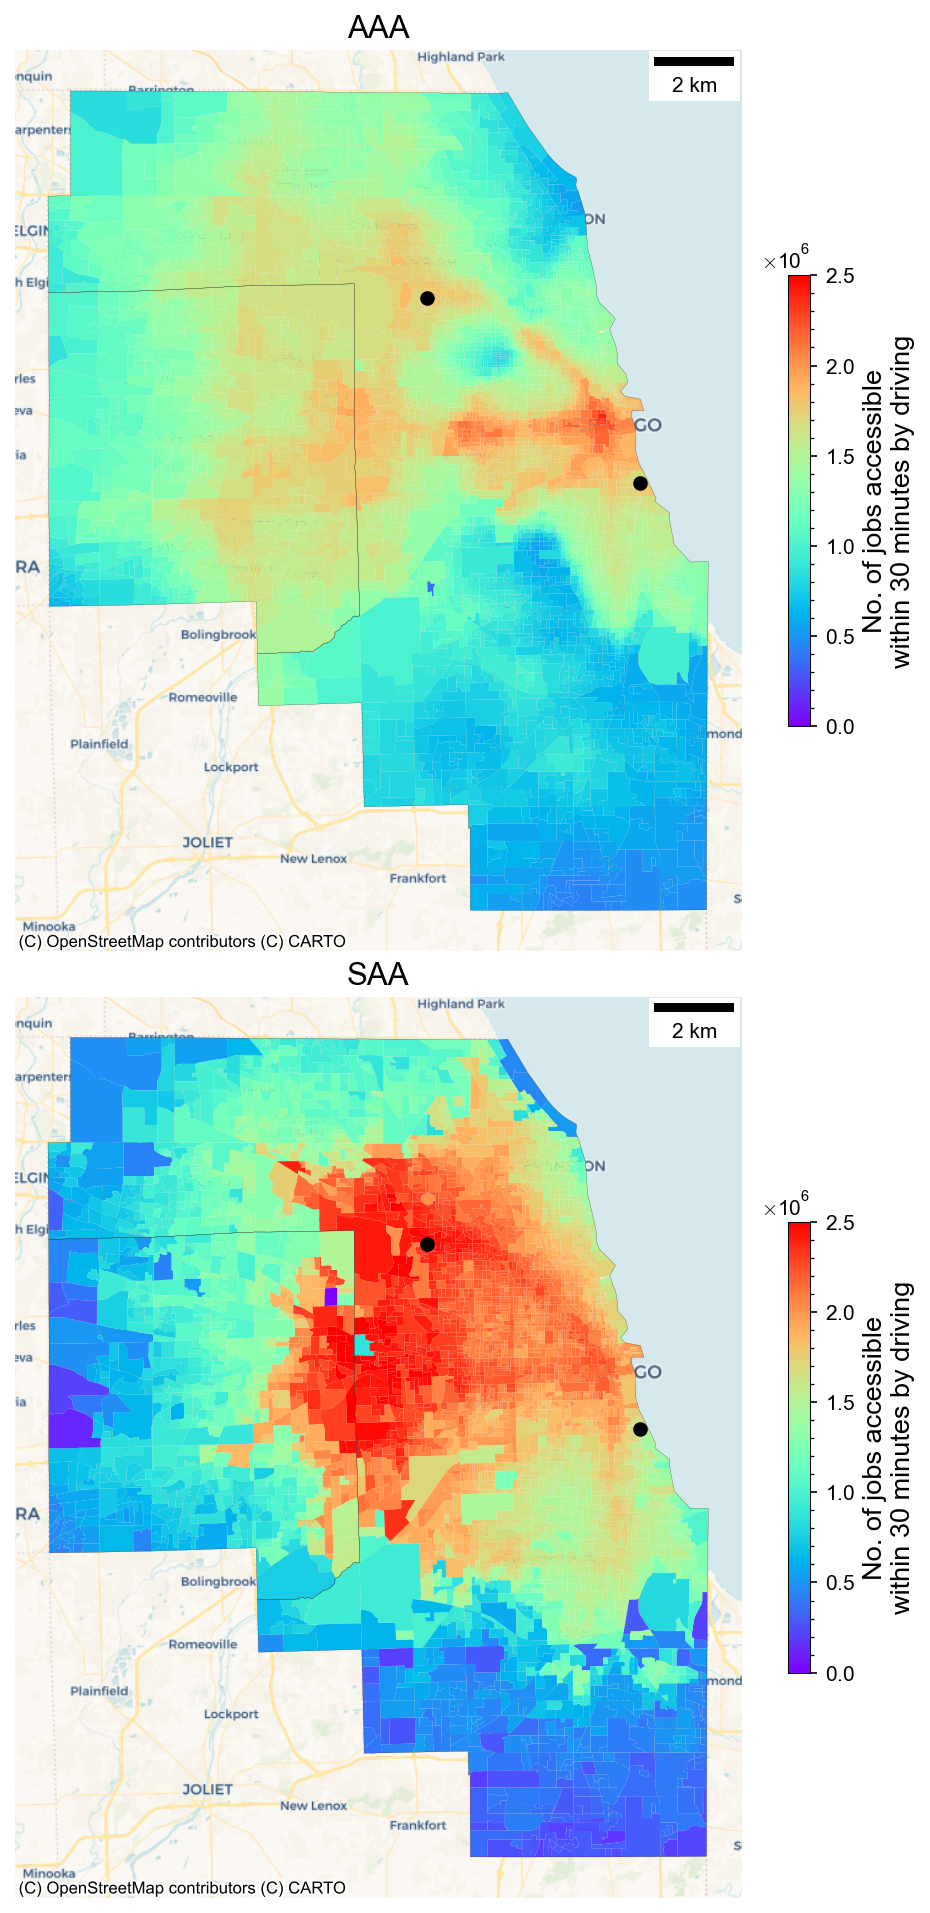

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16), dpi=150)
cbar_label = 'No. of jobs accessible\nwithin 30 minutes by driving'
for i, (col, label) in enumerate([('aaa', 'AAA'), ('saa', 'SAA')]):
    ax = plot(axes.flatten()[i], title=label, axoff=1)
    maplot(chi_xs, col, ax, vmin=0, vmax=2.5e6, label=cbar_label)
    chi_zones.dissolve('county').plot(ax=ax, fc='none', ec='k', lw=0.1)
    for geoid in ['170317608012', '170318365002']:
        filt(chi_zones, geoid=geoid).centroid.plot(ax=ax, color='k')
plt.subplots_adjust(hspace=0.05)
imsave('SAA vs AAA access distribution in Chicago')